# Resources
* [ https://developers.google.com/machine-learning/recommendation/overview/types ]
* [ https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system ]
* [ https://www.kaggle.com/kanncaa1/recommendation-systems-tutorial ]
* [ https://www.featuretools.com/demos/ ]

In [1]:
import os
import gc
import sys
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing :
from sklearn.preprocessing import MinMaxScaler,StandardScaler,scale
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

from sklearn.cluster import KMeans

#k fold
from sklearn.model_selection import StratifiedKFold,train_test_split,KFold
#metrics
from sklearn.metrics import balanced_accuracy_score,brier_score_loss



#deep learning
# import tensorflow as tf 
# from tensorflow.keras import layers
# from tensorflow.keras import Model
# from tensorflow.keras import backend as K



#training
from catboost import CatBoostClassifier as cb


#hyperparam optimization
import optuna
from optuna import Trial


import warnings 
warnings.filterwarnings('ignore')

**Training Data**

In [2]:
train=pd.read_csv('../input/geoffrey-hinton-fellowship-hackathon-2/Training Data.csv')
target=pd.read_csv('../input/geoffrey-hinton-fellowship-hackathon-2/Training Data Target.csv')
test=pd.read_csv('../input/geoffrey-hinton-fellowship-hackathon-2/Test Data.csv')

train.shape

(257407, 3)

In [3]:
train=train[train['user_id'].isin(target['user_id'])]
train.shape

(120198, 3)

In [4]:
categories=train.category.unique()
categories

array(['Home Decor', 'Fitness', 'Board Games', 'Back to School', 'Phones',
       'Fashion', 'Toys', 'Consumer Durables', 'Painiting Supplies',
       'TVs', 'Groceries', 'Gaming', 'Laptops', 'Beauty Products',
       'Pet Supplies', 'Books', 'Kitchen cleaning Supplies', 'Ereaders'],
      dtype=object)

In [5]:
print('Number of Unique Users {}'.format(train['user_id'].nunique()))

Number of Unique Users 13245


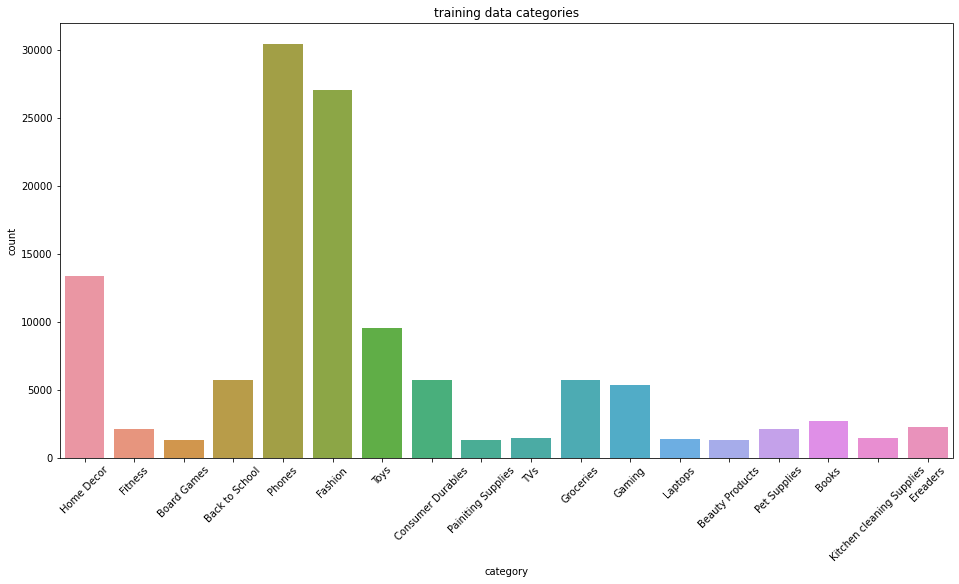

In [6]:
def plot_count(df,col,title):
    plt.subplots(figsize=(16,8))
    sns.countplot(df[col])
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()
    
    
plot_count(train,'category','training data categories')

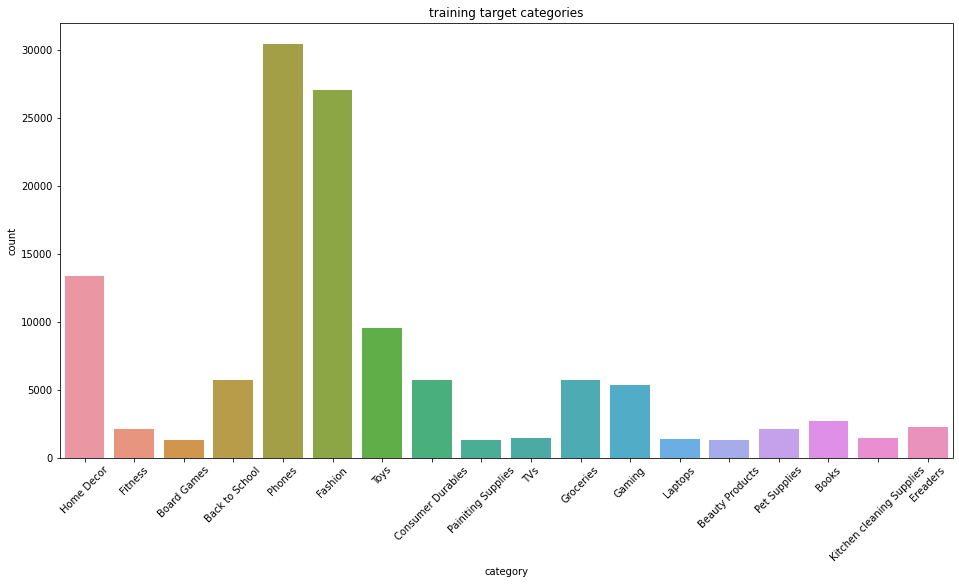

In [7]:
plot_count(train,'category','training target categories')

**Creating Features**

In [8]:
# K means
#finding ideal k by elbow method:

def find_ideal_k(m,df,cols):
    '''find ideal k for clustering using elbw method'''
    
    
    X_temp=scale(df[cols].copy())
    inertia=[]
    K=[i for i in range(2,m)]
    for k in K:
        km=KMeans(n_clusters=k)
        km.fit(X_temp)
        inertia.append(km.inertia_)
    
    plt.figure(figsize=(16,8))
    plt.plot(K,inertia)
    plt.xlabel('K')
    plt.ylabel('inertia')
    plt.show()
    
    del X_temp;gc.collect()

    
#category columns
# find_ideal_k(40,X,categories)   
# find_ideal_k(40,X,aov_cols)   


# **Feature Transformer**

In [9]:
class feature_transformer:
    '''make features out of data provided'''
    
    def __init__(self,
                 test_run=False):
        self.test_run=test_run
        self.super_categories=['Education_Hobbies_work','Electronics','Home','Personal','Kids']
        
        
    def agg_features(self,df):
        agg_cols=['median','min','max','sum','count','mean','std']
        
        #train
        aov_features=pd.DataFrame(df.groupby('user_id').agg({'aov':agg_cols})).droplevel(0,axis=1)
        aov_features.reset_index(inplace=True)
        aov_features.rename({k:f'{k}_aov' for k in agg_cols},axis=1,inplace=True)        

        
        self.aov_cols=list({k:f'{k}_aov' for k in agg_cols}.values())
        
        return aov_features
    
    
    def vectorize(self,df):
        '''return a dataframe with the customer interaction with products'''
        df1=pd.DataFrame()
        df1['user_id']=df['user_id'].unique()
        categories=df['category'].unique()
        df1[categories]=0


        df1[[f'{cat}_spend'for cat in categories]]=0     
               

        for user_id in df1.user_id:
            df_user=df[df['user_id']==user_id]


            for ids,row in df_user.iterrows():
                #number of times user has bought a particular category
                df1.loc[df1['user_id']==user_id,row['category']]+=1 

                #sum of money user has spend on that category
                df1.loc[df1['user_id']==user_id,row['category']+'_spend']+=row['aov']            

        return df1
    
    def avg_spend(self,row):
        '''avg spend for each category'''
        categories=list(self.categories)
        categories.extend(list(self.super_categories))
        
        for cat in categories:
            if row[cat]!=0:
                row[cat + '_avg' + '_spend']=row[cat + '_spend']/row[cat]
            else:
                row[cat + '_avg' + '_spend']=0
                
        return row
    

    
    def sup_categ(self,
                  df):
        '''count of Items purchased from these super categories'''
        
        sup_categories=self.super_categories
        
        Education_Hobbies_work=['Back to School','Painiting Supplies','Laptops',
                               'Books','Ereaders','Board Games','Gaming']
        
        Electronics=['Phones','TVs','Gaming','Laptops','Ereaders']
        Personal=['Fitness','Fashion','Consumer Durables','Beauty Products']
        Home=['Home Decor','Consumer Durables','TVs','Groceries',
              'Kitchen cleaning Supplies','Pet Supplies']
        Kids=['Board Games','Back to School','Toys','Gaming']
        
        for cat in sup_categories:
            #count in super cat
            df[f'{cat}']= df[eval(cat)].sum(axis=1)
            
            #amount spend in each super cat
            df[f'{cat}_spend']= df[[str(i)+'_spend' for i in eval(cat)]].sum(axis=1)
            
            
        return df
             

    def cluster_features(self,
                         X,X_test,
                         num_init=50):
        
        categories=[f'{c}_spend' for c in self.categories]
        aov_cols=self.aov_cols
        sup_categories=[f'{c}_spend' for c in self.super_categories]

        #categories 
        km_pipe=KMeans(n_clusters=15,n_init=num_init,init='k-means++')

        X['Cluster_categories']=km_pipe.fit_predict(X[categories])
        X_test['Cluster_categories']=km_pipe.predict(X_test[categories])
        
        #super Categories
        km_pipe=KMeans(n_clusters=10,n_init=num_init,init='k-means++')
        X['Cluster_Sup_cat']=km_pipe.fit_predict(X[sup_categories])
        X_test['Cluster_Sup_cat']=km_pipe.predict(X_test[sup_categories])
        
        

        #aov cols
        km_pipe=Pipeline([('scale',StandardScaler()) ,
                          ('kmeans',KMeans(n_clusters=10,n_init=num_init,init='k-means++'))])

        X['Cluster_aov']=km_pipe.fit_predict(X[aov_cols])
        X_test['Cluster_aov']=km_pipe.predict(X_test[aov_cols])    

        return X,X_test
    
    def transform(self,
                 train_df,
                 test_df):
        self.categories=train_df['category'].unique()
        
        if self.test_run:
            train_df=train_df.sample(1000)
            test_df=test_df.sample(1000)
            
        
#       train features
        X=self.vectorize(train_df)
        X=self.sup_categ(X)
        X=X.merge(self.agg_features(train_df),on='user_id',how='inner')
        X=X.apply(lambda x: self.avg_spend(x),axis=1)
        X=X.fillna(0)
        
        
        #test features        
        X_test=self.vectorize(test_df)
        X_test=self.sup_categ(X_test)
        X_test=X_test.merge(self.agg_features(test_df),on='user_id',how='inner')
        X_test=X_test.apply(lambda x: self.avg_spend(x),axis=1)
        X_test=X_test.fillna(0)
        
        
        #cluster
        X,X_test=self.cluster_features(X=X,
                                      X_test=X_test)

        
        return X,X_test
    

In [10]:
%%time

#make features
    
feature_transformer=feature_transformer(test_run=False)

X,X_test=feature_transformer.transform(train_df=train,
                                       test_df=test)

CPU times: user 36min 47s, sys: 3min 28s, total: 40min 16s
Wall time: 28min 45s


In [11]:

#merge target
X=X.merge(target[['user_id','category']],on='user_id',how='inner')


#reset index
X.reset_index(inplace=True,drop=True)
X_test.reset_index(inplace=True,drop=True)
X.shape

(13245, 81)

In [12]:
#encoding target category
label_enc=LabelEncoder()
X['category']=label_enc.fit_transform(X['category'])
classes=label_enc.classes_                        

#num_classes
num_classes=len(classes)
num_classes

14

In [13]:
# train data 
y=X.pop('category')

tr_class=y.unique()


#cal class weights if required
weights = compute_class_weight(class_weight='balanced', 
                               classes=tr_class, 
                               y=y)

class_weights = dict(zip(tr_class, weights))


assert set(X.columns)==set(X_test.columns), 'columns donot match'

In [14]:
#user ids
train_user_ids=X.pop('user_id')
test_user_ids=X_test.pop('user_id')

In [15]:
#columns with categorical features

categorical_columns=['Cluster_categories','Cluster_aov','Cluster_Sup_cat']

<AxesSubplot:ylabel='Frequency'>

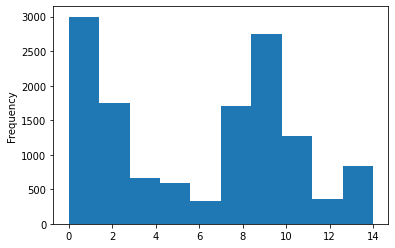

In [16]:
X['Cluster_categories'].plot(kind='hist')


# **OPTUNA Hyperparam optimization**

In [17]:
def objective(trial:Trial):
    
    #splitting training data 
    x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=7,
                                                  train_size=0.7, stratify=y)
    
    #hyperparam_grid
    params={   'verbose'        : 0,
               'loss_function'  :'MultiClass',
               'classes_count'  : len(classes),
               'depth'          :trial.suggest_int('depth',4,8),
               'learning_rate'  :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
               'l2_leaf_reg'    :trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),
               'random_strength':trial.suggest_uniform('random_strength',1e-2,0.3),
               'max_bin'        :trial.suggest_int('max_bin',64,254),
#                'grow_policy'    :trial.suggest_categorical('grow_policy',
#                                                            ['SymmetricTree','Depthwise','Lossguide']),
               'iterations'     :trial.suggest_int('iterations',1000,2000),
#                'max_leaves'     :trial.suggest_int('max_leaves',2,64),
               "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 0.6),
#                "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
               "bootstrap_type": 'MVS',
#                                  trial.suggest_categorical("bootstrap_type",
#                                                            ["Bayesian", "MVS",'Bernoulli']),
               'eval_metric': 'MultiClass'
                }
    
    
    try:
        model = cb(**params)

        model.fit(x_train,y_train,
                 eval_set=[(x_test,y_test)],
                 verbose=0,
                 cat_features=categorical_columns,
                 early_stopping_rounds=300)
#                  class_weights=cw)

        preds=model.predict(x_test)

        acc= balanced_accuracy_score(y_test,preds)
        
        return acc

    except Exception as e:
        print(e)
        return None
   
    

In [18]:
def get_best_params(time_out=9000):
    sampler = optuna.samplers.TPESampler(seed=7)  # Make the sampler behave in a deterministic way.
    study=optuna.create_study(direction='maximize',sampler=sampler)
    study.optimize(objective, n_trials=300, timeout=time_out)
    
    print("Number of finished trials: {}".format(len(study.trials)))
    
    return study.best_trial.params

# best_params=get_best_params()

In [19]:
#29/7/21
best_params={
             'verbose'        : 0,
             'loss_function'  :'MultiClass',
             'classes_count'  : len(classes),
             "bootstrap_type": 'MVS',
             'depth': 4, 
             'learning_rate': 0.06365747563313634,
             'l2_leaf_reg': 0.14164990508678563,
             'random_strength': 0.18177681941882445,
             'max_bin': 254,
             'iterations': 3000,
#             1505
             'colsample_bylevel': 0.4732653286911665}


# 26/7/21
# best_params={
#              'verbose'        : 0,
#              'loss_function'  :'MultiClass',
#              'classes_count'  : len(classes),
#              "bootstrap_type": 'MVS',
#              'depth': 5,
#              'learning_rate': 0.09962164243695339,
#              'l2_leaf_reg': 1.2575960096355996,
#              'random_strength': 0.07176128132724813,
#              'max_bin': 220, 
#              'iterations': 1206, 
#              'colsample_bylevel': 0.5598653634090404}

# 25/7/21
# best_params={
#              'verbose'        : 0,
#              'loss_function'  :'MultiClass',
#              'classes_count'  : len(classes),
#              "bootstrap_type": 'MVS',
#              'depth': 4, 
#              'learning_rate': 0.07240696360883225, 
#              'l2_leaf_reg': 0.37748668450031264, 
#              'random_strength': 0.14114940406399043, 
#              'max_bin': 170, 'iterations': 2148, 
#              'colsample_bylevel': 0.41308547541216933}

# Model Fitting and Prediction

In [20]:
def k_fold_predict(k,
                  params=best_params):
    
    
    skf=StratifiedKFold(n_splits=k)
    
    mean_preds=np.zeros(shape=(X_test.shape[0],len(classes)))
    train_check=np.zeros(shape=(X.shape[0],len(classes)))
    
    

    for train_idx,val_idx in skf.split(X,y):
        x_t,x_v=X.iloc[train_idx],X.iloc[val_idx]
        y_t,y_v=y.iloc[train_idx],y.iloc[val_idx]
        
        model=cb(**params)        
        model.fit(x_t,y_t,
                 cat_features=categorical_columns)
        
        print('Validation score {}'.format(balanced_accuracy_score(
                                            y_v,model.predict(x_v))))
        
        #test predictions
        mean_preds+=model.predict(X_test,prediction_type='Probability')
        
        #training preds
        train_check+=model.predict(X,prediction_type='Probability')
    
    mean_preds=mean_preds/k
    train_check=train_check/k
    
    return mean_preds,train_check

In [21]:
%%time
preds,train_ch=k_fold_predict(30)

preds=pd.DataFrame(preds)
train_preds=pd.DataFrame(train_ch)

Validation score 0.6520016691865032
Validation score 0.671394756486618
Validation score 0.7079493769357268
Validation score 0.688374383145424
Validation score 0.6970222490618507
Validation score 0.7129756945388742
Validation score 0.6830514806827644
Validation score 0.6428552754034151
Validation score 0.6542904451183716
Validation score 0.5803419210543611
Validation score 0.5889532548966682
Validation score 0.5865199579280619
Validation score 0.690080947352961
Validation score 0.5942958816340267
Validation score 0.6355694470356242
Validation score 0.6151566423795438
Validation score 0.6420673126753458
Validation score 0.666764737307299
Validation score 0.6513762442323947
Validation score 0.7062648707439135
Validation score 0.6437313072609829
Validation score 0.6453351787315859
Validation score 0.664195165192497
Validation score 0.6522924845281749
Validation score 0.7026227025003675
Validation score 0.6682017751446666
Validation score 0.6095368269728139
Validation score 0.67026146248609

In [22]:
preds.rename(columns={i:classes[i] for i in range(len(classes))},inplace=True)
preds.head()

,Back to School,Consumer Durables,Ereaders,Fashion,Fitness,Gaming,Groceries,Home Decor,Kitchen cleaning Supplies,Laptops,Pet Supplies,Phones,TVs,Toys
0,1.094957e-06,0.000016,0.000015,0.004504,0.000054,2.109298e-07,4.799936e-08,0.000813,1.594228e-09,3.676002e-07,0.000195,0.994345,3.211285e-06,0.000054
1,7.345921e-08,0.000056,0.053747,0.578522,0.000774,1.964040e-08,2.348524e-09,0.001336,9.862851e-10,2.947302e-05,0.000016,0.365499,7.902727e-07,0.000019
2,1.000326e-08,0.000017,0.000011,0.004068,0.000030,2.347310e-08,3.617209e-07,0.001132,1.701326e-09,1.071647e-06,0.000317,0.994399,3.131201e-06,0.000021
3,7.381571e-07,0.003013,0.000005,0.034779,0.000017,5.518118e-07,4.505413e-07,0.767688,5.798301e-09,6.629225e-07,0.005018,0.187351,2.072317e-03,0.000054
4,4.101562e-09,0.000051,0.000005,0.004683,0.000052,4.083016e-09,4.370335e-08,0.000393,3.400542e-10,3.435257e-07,0.000378,0.994428,2.180858e-06,0.000006


In [23]:
# mean predictions for each class
np.mean(preds,axis=0)

Back to School               0.000396
Consumer Durables            0.006254
Ereaders                     0.039914
Fashion                      0.096180
Fitness                      0.037462
Gaming                       0.000046
Groceries                    0.000066
Home Decor                   0.008328
Kitchen cleaning Supplies    0.000015
Laptops                      0.013404
Pet Supplies                 0.035043
Phones                       0.742248
TVs                          0.018946
Toys                         0.001699
dtype: float64

In [24]:
# mean predictions for each class(training_data)
pd.DataFrame({'predicted_ratio':np.mean(train_preds,axis=0),
              'actual_ratio': y.value_counts(1)})

,predicted_ratio,actual_ratio
0,0.001282,0.001435
1,0.013918,0.014043
2,0.067282,0.066969
3,0.166565,0.165723
4,0.066052,0.065987
5,0.000681,0.000755
6,0.000554,0.000604
7,0.017701,0.017969
8,0.000136,0.000151
9,0.023264,0.023254


**Predicting Top Three categories based on predicted Probablities**

In [25]:
def get_top_cat(row,classes):
    '''get the top 3 predicted categories'''
    prob,top_3 = zip(*sorted(zip(row.values,classes),reverse=True)[:3])
    top_3=', '.join(top_3)
    
    return top_3


In [26]:
get_top_cat(preds.iloc[0],classes)

'Phones, Fashion, Home Decor'

In [27]:
get_top_cat(preds.iloc[180],classes)

'Phones, Fashion, Pet Supplies'

In [28]:
df_preds=pd.DataFrame()
df_preds['user_id']=test_user_ids
df_preds['pred3']=0

In [29]:
for i in range(len(preds)):
    df_preds.loc[i,'pred3']=get_top_cat(row=preds.iloc[i,:],classes=classes)

In [30]:
df_preds.head()

,user_id,pred3
0,43323.0,"Phones, Fashion, Home Decor"
1,4269.0,"Fashion, Phones, Ereaders"
2,21731.0,"Phones, Fashion, Home Decor"
3,14422.0,"Home Decor, Phones, Fashion"
4,12862.0,"Phones, Fashion, Home Decor"


In [31]:
df_preds.to_csv('submission.csv',index=False)

In [32]:

# def mean_relevance_rank(top_category,predicted_categories):
#     '''get a mean relevance rank for a given prediction.'''
#     mrr=float(1/(1+i) for i in range(len(predicted_categories.split(','))) \
#         if predicted_categories.split(',')[i]==top_category else 0)
    
#     return mrr

# def precision_rank(top_category,predicted_categories):
#     '''return a precision rank for given prediction'''
#     pr=1 if top_catgory in predicted_categories else 0
    
#     return pr
